# Few-Shot Learning - Practical 1
___

Our first step is to grab all the imports we will need for this practical. We won't need too much to start out with, just NShot and our workshop utilities package. 

### Part 0: Imports

In [1]:
import utils
import torch

%matplotlib inline

### Part 1: Sample episode from CIFAR 10

For this practical we will be working with a small subset of the CIFAR 10 dataset. This dataset is comprised of 10 classes of 32 x 32 pixel images. Our few-shot task will be subsampled down from these 10 classes. The default configuration will sample 5 classes and random and 5 images from each of those classes to define our support set and then pull the rest of the CIFAR 10 sample as the query set.

The command below builds and resets the `cifar_sample` and `episode` directories. 

In [2]:
utils.reset_data()

Resetting data... Done.


Next we assemble an episode from the generated directories. To get more information on our utility functions remember that you can always run `help(function_name)`.

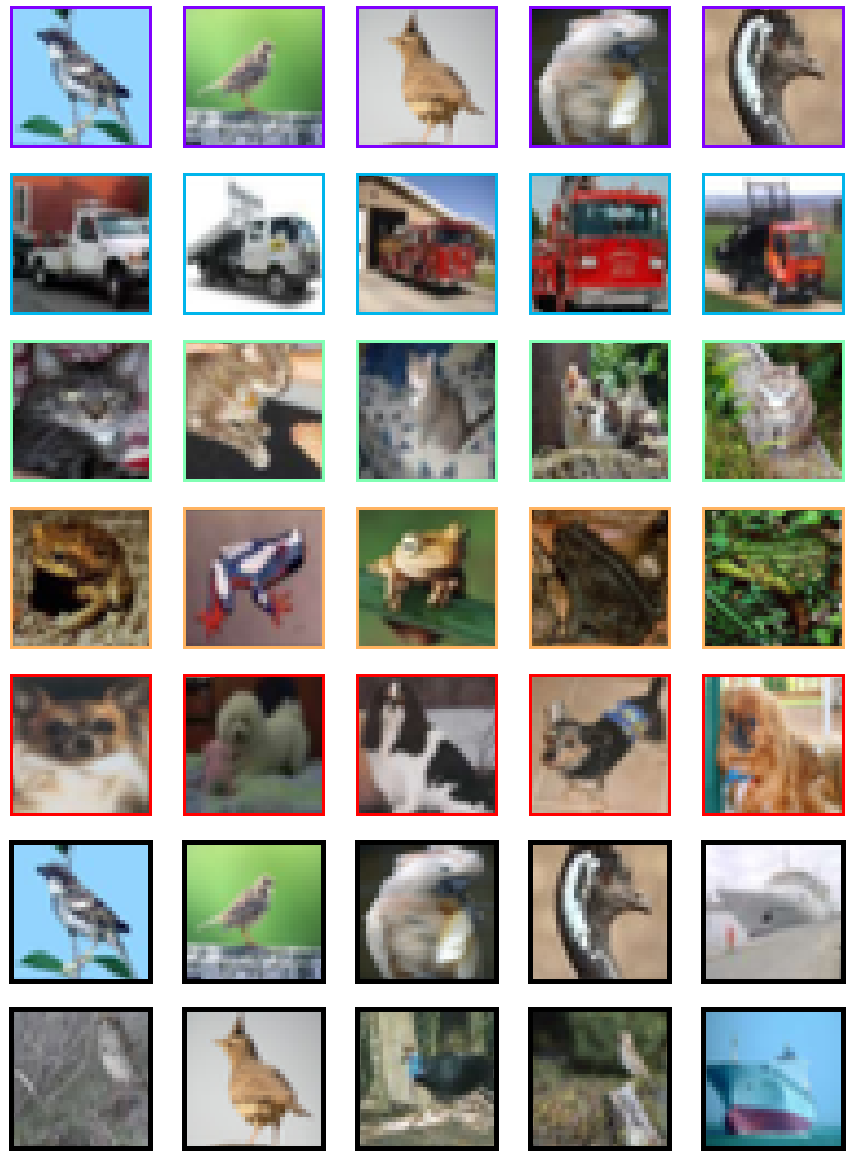

In [3]:
episode, support_classes = utils.get_episode('episode', preprocess_images=False)
utils.visualize(episode, query_rows=2, scale=3)

In [4]:
help(utils.visualize)

Help on function visualize in module utils.main:

visualize(episode, query_rows=None, scale=3)



### Part 2: Instantiate a ProtoNets model from the utils package

For this exercise we will be using a basic ProtoTypical Network architecture along with a ResNet 18 encoder. Recall that ProtoNets simply uses a Euclidean distance to measure similarity between query points and the average of support class vectors. Since this operation is entirely predefined the only trainable parameters exist within the encoder architecture itself. 

In [5]:
encoder = utils.ResNet()
model = utils.ProtoNets(encoder)

model = model.eval()
model.load('/home/shared/weights/protonets_weights.pt')

We can print the model componenets (mostly the ResNet componenets) by printing the model. Note that the last fully connected layer is used to train ResNet when classically trained but is ignored in the few-shot context.

In [6]:
print(model) # The focus of this notebook is not the model architecture so this is commented out by default

ProtoNets(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### Part 3: Running Predictions
Our last step before plugging our episode into our model is to run a little preprocessing on the images themselves. Right now they are stored in our episode object as PIL images. We need to normalize their size and convert them over to tensors. To do that we can make use if a standard preprocesssing function stored at `utils.preprocess`. This is done below.

In [7]:
episode['support'] = [utils.preprocess(image) for image in episode['support']]
episode['query'] = [utils.preprocess(image) for image in episode['query']]

Now that we have our model and our episode we can put them together and actually get an output from our model.

In [8]:
with torch.no_grad():
    logits = model(episode)

print(utils.softmax(logits, dim=1))
print(logits.shape)

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 5.3978e-42, 0.0000e+00, 6.6409e-26, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.6662e-29, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 5.1246e-13, 0.0000e+00, 9.0038e-15, 7.0065e-45],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 6.1137e-32, 0.0000e+00],
        [2.1905e-41, 6.9063e-39, 1.3496e-41, 6.2266e-36, 1.0000e+00],
        [4.6491e-33, 1.3554e-35, 2.6194e-30, 1.2419e-24, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.4299e-07, 9.3992e-25, 1.0000e+00, 3.3012e-15, 3.8886e-23],
        [1.6254e-06, 1.7407e-14, 2.2793e-06, 1.0000e+00, 1.7968e-21],
        [4.1738e-28,

That gave us a lot of numbers! Lets see if we can piece through this and nail down exactly what images these numbers correspond to. First we can save our episode seperately before and after preprocessing:

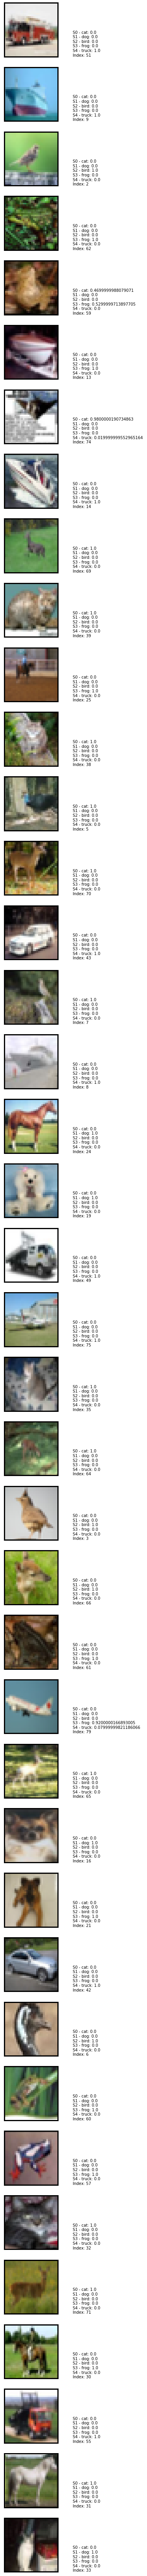

In [40]:
images_episode, support_classes = utils.get_episode('episode', preprocess_images=False)
tensor_episode, support_classes = utils.get_episode('episode', preprocess_images=True)

with torch.no_grad():
    logits = model(tensor_episode)
    
utils.visualize_predictions(
    images_episode,
    logits,
    num_queries=40,
    support_classes=support_classes,
    random_order=True
)

### Part 4: Getting intuition for model behavior
The block of code will let us run our model with a support set defined in the `episode_dir` and a query set defined in the `query_dir`. Take some time and play around with how changing the support set can impact performance on the query set. Here's a few things to try:
- Add new classes to the support set that don't appear the query set
- Add new classes in the query set that don't appear in the support set
- Decrease or increase the number of support classes
- Grab images from domains entirely different from CIFAR10

```python
images_episode, support_classes = utils.get_episode(episode_dir, query_dir=query_dir, preprocess_images=False)
tensor_episode, support_classes = utils.get_episode(episode_dir, query_dir=query_dir, preprocess_images=True)

with torch.no_grad():
    logits = model(tensor_episode)

utils.visualize_predictions(
    images_episode,
    logits,
    num_queries=10,
    support_classes=support_classes
)
```

In [21]:
episode_dir = 'episode'
#query_dir = 'cifar_sample'
query_dir = 'adv_examples'

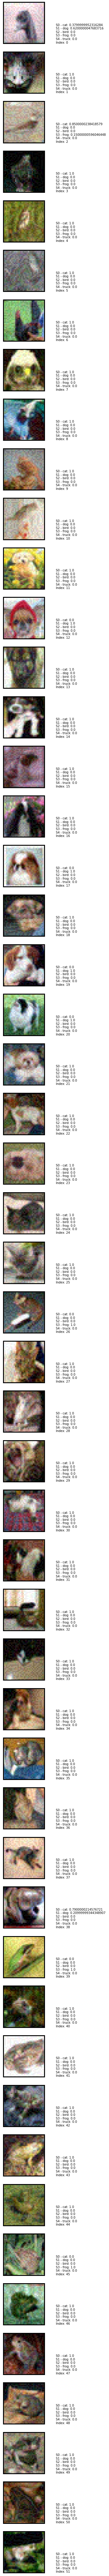

In [26]:
images_episode, support_classes = utils.get_episode(episode_dir, query_dir=query_dir, preprocess_images=False)
tensor_episode, support_classes = utils.get_episode(episode_dir, query_dir=query_dir, preprocess_images=True)

with torch.no_grad():
    logits = model(tensor_episode)

utils.visualize_predictions(
    images_episode,
    logits,
    num_queries=52,
    support_classes=support_classes
)

In [31]:
!ls adv_examples/frog

frog_adv0bird.png   frog_adv14cat.png	frog_adv3cat.png   frog_adv7cat.png
frog_adv11bird.png  frog_adv15cat.png	frog_adv4bird.png  frog_adv8bird.png
frog_adv12cat.png   frog_adv16bird.png	frog_adv5cat.png
frog_adv13bird.png  frog_adv2bird.png	frog_adv6bird.png


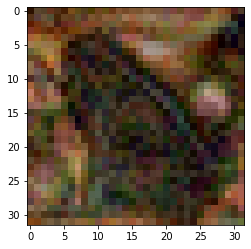

In [43]:
import matplotlib.image as img 
import matplotlib.pyplot as plt 
# reading png image file 
im = img.imread('adv_examples/frog/frog_adv3cat.png') 
  
# show image 
plt.imshow(im)

In [44]:
!ls adv_examples/cat

cat_adv0frog.png   cat_adv13frog.png  cat_adv2frog.png	cat_adv7frog.png
cat_adv10frog.png  cat_adv14bird.png  cat_adv3frog.png	cat_adv9frog.png
cat_adv11frog.png  cat_adv15dog.png   cat_adv4dog.png
cat_adv12bird.png  cat_adv16bird.png  cat_adv5bird.png


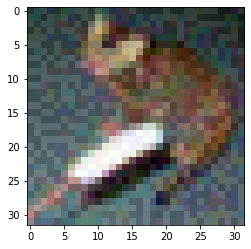

In [46]:
# reading png image file 
im = img.imread('adv_examples/cat/cat_adv10frog.png') 
  
# show image 
plt.imshow(im)